In [1]:
import glob
from datetime import datetime
from pandasql import sqldf
import pandas as pd
from ggplot import *
%matplotlib inline

pysqldf = lambda q: sqldf(q, globals())

In [2]:
# Load specified columns of all CSV's into a DataFrame

file_list = glob.glob('nypd-sqf-data/*.csv')
cols = ['datestop', 'race', 'frisked', 'searched', 'contrabn']

dataset = pd.DataFrame()
for file in file_list:
#     print("Loading into dataframe: ", file)
    frame = pd.read_csv(file, usecols=cols, na_values=' ', low_memory=False)
#     frame['total'] = len(frame)
    dataset = pd.concat([dataset, frame], ignore_index=True)

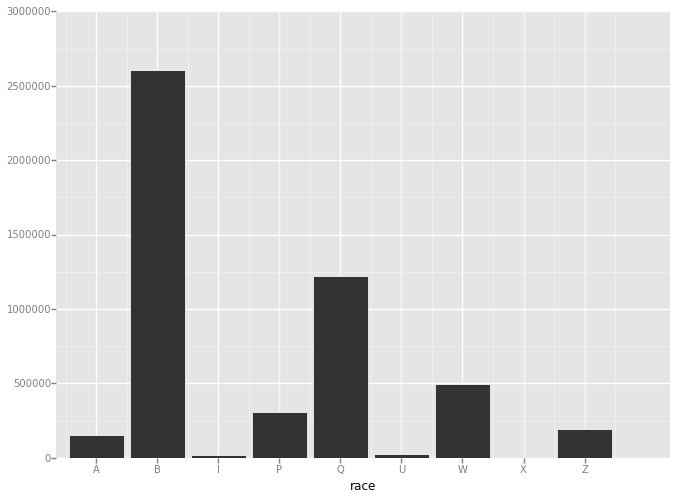

<ggplot: (-9223372036574542094)>

In [3]:
# View Histogram of Different Races
ggplot(aes('race'), dataset) + geom_histogram()

In [4]:
# q = """
# SELECT datestop, race, frisked, searched, contrabn, count(*) AS stops
# FROM dataset 
# GROUP BY datestop, race
# """

q = """
SELECT datestop, race, count(*) AS stops
FROM dataset 
GROUP BY datestop, race
"""

racedf = pysqldf(q)
racedf.head()

# dataset.groupby(['datestop', 'race'], as_index=False)['race', 'contrabn'].sum()

,datestop,race,stops
0,None,B,2
1,10012003,A,13
2,10012003,B,257
3,10012003,P,24
4,10012003,Q,150


In [5]:
# Select Subset of Races
races = racedf.loc[(racedf.race.str.contains("A|B|P|Q|W")) & (racedf.race.notnull())].copy()

# Drop Missing Values
races = races.dropna()

# Map Black-Hispanic + White-Hispanic to single Hispanic variable
races['race'] = races['race'].map({'B':'B', 'W':'W', 'P':'H', 'Q':'H', 'A':'A'})

## Map Y/N to 1/0
# races['frisked'] = races['frisked'].map({'Y':1, 'N':0})
# races['searched'] = races['searched'].map({'Y':1, 'N':0})
# races['contrabn'] = races['contrabn'].map({'Y':1, 'N':0})

races.head()

,datestop,race,stops
1,10012003,A,13
2,10012003,B,257
3,10012003,H,24
4,10012003,H,150
5,10012003,W,65


In [6]:
def fix_dates(df):
    add_zero = lambda x: str(x).zfill(8)
    df['datetime'] = pd.to_datetime(df['datestop'].map(add_zero), format="%m%d%Y", errors='coerce')
    
    df.loc[races['datetime'].isnull(),'datetime'] = pd.to_datetime(df.loc[df['datetime'].isnull(),'datestop'])

    df = (df.drop(['datestop'], 1)
            .loc[(races.datetime > '2000-01-01')]
            .sort_values('datetime'))
    
    df['months'] = pd.to_datetime(df['datetime'].map(lambda x: (x.year, x.month, 1)), format='(%Y, %m, %d)')

    return df.drop(['datetime'], 1)

In [7]:
races = fix_dates(races)
races.head(10)

,race,stops,months
918,H,59,2003-01-01
919,W,26,2003-01-01
917,H,14,2003-01-01
916,B,146,2003-01-01
915,A,3,2003-01-01
1829,W,57,2003-01-01
1827,H,30,2003-01-01
1825,B,161,2003-01-01
1824,A,11,2003-01-01
1828,H,112,2003-01-01


In [12]:
## Add monthly totals
def add_prop(df):
    '''Add proportion column to df'''
    for month in df.months.unique():
        df.loc[(df.months == month), 'month_tot'] = sum(df.loc[(df.months == month), 'stops'])

    df['prop'] = df['stops']/df['month_tot']
    
    return df

def add_race_prop(df):
    '''Add proportion column to df'''
    for month in df.months.unique():
        for race in df.race.unique():
            df.loc[(df.months == month) & (df.race == race), 'month_tot'] = sum(df.loc[(df.months == month) & (df.race == race), 'stops'])

    df['race_prop'] = df['stops']/df['month_tot']
    
    return df

In [15]:
danwin = races.groupby(['months', 'race'], as_index=False)['stops'].sum()
danwin = add_prop(danwin)
danwin.head()

,months,race,stops,month_tot,prop
0,2003-01-01,A,431,12563,0.034307
1,2003-01-01,B,6413,12563,0.510467
2,2003-01-01,H,4077,12563,0.324524
3,2003-01-01,W,1642,12563,0.130701
4,2003-02-01,A,282,10017,0.028152


In [16]:
danwin.to_csv('danwin.csv', index=False)

In [ ]:
# tmp = races.loc[races.race.str.contains('B|W|P|Q')].copy()
# tmp['race'] = tmp['race'].map({'B':'B','W':'W','P':'H','Q':'H'})
# tmp = tmp.groupby(['monthly', 'race'], as_index=False)['stops', 'prop'].sum()